# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
from nltk.tokenize import word_tokenize, sent_tokenize
import pickle
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedhafez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedhafez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ahmedhafez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 
# Functions

**`PreprocessListCategories`** <br>
`Function take df, list of categories columns and apply OHE on them, then return the df after modifications`

In [2]:
def PreprocessListCategories(df, lst):
    for col in lst:
        # Apply one-hot encoding to the "col" column in list and put the output in newdf
        newdf = df[col].str.get_dummies(sep=', ')
        df.drop(columns=[col], inplace=True)
        # Concatenate the one-hot encoded columns with the original DataFrame
        df = pd.concat([df, newdf], axis=1)
        
    return df

**`CheckNullRows`**<br>
`Function take df and print number of null rows`

In [3]:
def CheckNullRows(df):
    missing_rows = df.isnull().any(axis=1).sum()
    print('Number of rows that have null values: ', missing_rows)

**`DropNullRows`**<br>
`Function take df and drop all null rows`

In [4]:
def DropNullRows(df):
    df.dropna(inplace=True)

**`ChangeDataType`**<br>
`Function take df and change data types of some columns to appropriate data type`

In [5]:
def PreProcessAgrRating(df):
    # Age Rating 
    # Print current data type
    print('Data type of Age Rating is, ', df['Age Rating'].dtype)
    # Remove the + sign
    df['Age Rating'] = df['Age Rating'].str.replace('+', '', regex=False)
    # Convert Column datatype to int
    df['Age Rating'] = df['Age Rating'].astype(int)
    print('Data type of Age Rating after processing is ', df['Age Rating'].dtype)
    # Create a dictionary to map the age ratings to integers
    age_rating_map = {4: 1, 9: 2, 12: 3, 17: 4}
    # Replace each value with its category
    df['Age Rating'] = df['Age Rating'].replace(age_rating_map)
    # Print Age Rating
    print(df['Age Rating'].head())

In [6]:
def dropColumns(df, lst):
    for col in lst:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

In [7]:
def ConvertToDateTime(df, lst):
    for col in lst:
        df[col] = pd.to_datetime(df[col].astype('datetime64'),dayfirst=True).astype('int64')

In [8]:
def GetColumnsNullsPerc(df):
    # print count of nulls for each column and percentage of them
    missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().mean())*100})
    return missing_data

In [9]:
def CheckListOfCategoriesColumn(df, col):
    print("Data type of ", col, "column is: ", df[col].dtype)
    all_languages = list(set(','.join(df['Languages'].fillna('').unique()).split(',')))
    print(col, "column has ", len(all_languages), "unique", col)

In [10]:
def PrintDfColumns(df):
    columns_list = df.columns.tolist()
    print(columns_list)

In [11]:
def FillColumnNulls(df, col):
    df[col] = df[col].fillna(0)

In [12]:
def DuplicatesDetectionAndRemoval(df):
    print("Number of duplicates rows: ", df.duplicated().sum())
    df.drop_duplicates(inplace = True, keep="first")

In [13]:
def outliers(dataset,col):
    fig, ax =plt.subplots(1,2)
    sns.boxplot( y=col, data=dataset,color="red", ax=ax[0])
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    dataset[col]=dataset[col].apply(lambda x: upper_bound if x> upper_bound else( lower_bound if x< lower_bound  else x))        
    sns.boxplot( y=col, data=dataset,color="blue", ax=ax[1])
    fig.show()

In [14]:
def avarage_Purchases(data,col):
    data[col]=data[col].fillna("0")
    data[col]=data[col].astype(str)
    data[col]=data[col].str.split(",")
    data[col]=[np.float64(x) for x in data[col]]
    data[col]=data[col].apply(lambda x: mean(x))
    data[col]=data[col].astype(float)
    return data

In [15]:
def reduceOHEColumns(df):
    X = df.iloc[:,14:] #columns of categories [languages, generes, ]
    zero_percentage = pd.DataFrame({'total_zeros': (X == 0).sum(), 'perc_zeros': (X == 0).mean() * 100})
    to_keep = zero_percentage['perc_zeros'] < 90
    
    updatedX = X.loc[:, to_keep]
    df = df.drop(df.columns[18:], axis=1)
    
    result = pd.concat([df, updatedX], axis=1)
    return result

In [16]:
def extract_country(links):
    us_words = []
    for link in links:
        parsed_url = urlparse(link)
        try:
            us_word = parsed_url.path.split('/')[1]
            us_words.append(us_word)
        except IndexError:
            print(f"Malformed link: {link}")
    return us_words

In [17]:
def extract_color(links):
    is_color_list = []
    for link in links:
        parsed_url = urlparse(link)
        netloc = parsed_url.netloc.lower()
        is_color_match = re.search(r"is\d", netloc)
        if is_color_match:
            is_color = is_color_match.group()
        else:
            is_color = None
        is_color_list.append(is_color)
    return is_color_list

In [18]:
def count_dev_games(df):
  # Create a dictionary to store the frequency of each developer
  developer_freq = df['Developer'].value_counts().to_dict()

  # Replace each developer name with its frequency in the dataset
  df['Developer'] = df['Developer'].map(developer_freq)
  return df

In [19]:
def frequent_words_in_name(df):
       # Download the stop words and tokenizer if needed
    nltk.download('stopwords')
    nltk.download('punkt')

    # Define the stop words list
    stop_words = set(stopwords.words('english'))

    # Create an empty Counter object to store the word frequencies
    word_freq = Counter()

    # Iterate over each row in the 'Name' column
    for name in df['Name']:
        # Check if the value is a string before tokenizing it
        if isinstance(name, str):
            # Tokenize the name string into words
            words = word_tokenize(name)

            # Filter out stop words and iterate over each word
            for word, pos in nltk.pos_tag(words):
                # Filter out stop words and check if the word is a noun or verb
                if word not in stop_words and (pos.startswith('N') or pos.startswith('V')):
                    # Add the word to the counter
                    word_freq[word.lower()] += 1

    # Get the 50 most frequent words
    most_common_words = [word[0] for word in word_freq.most_common(50)]

    # Replace each word in the 'Name' column with 1 if it matches one of the 50 most frequent words
    df['Name'] = df['Name'].apply(lambda x: sum(1 for word in word_tokenize(str(x).lower()) if word in most_common_words) + 1)

    return df

In [20]:
def scaling(df):
  #use Min-Max scaling, which scales the data to a range between 0 and 1.
  # Initialize the MinMaxScaler object
  scalerA = MinMaxScaler()
  scalerB = MinMaxScaler()
  # Fit and transform the features
  df['User Rating Count'] = scalerA.fit_transform(df[['User Rating Count']])
  df['Size'] = scalerB.fit_transform(df[['Size']])
  with open('sA.pkl', 'wb') as file:
      pickle.dump(scalerA,file)
  with open('sB.pkl', 'wb') as file:
      pickle.dump(scalerB,file)  
  return df

In [21]:
def apply_scaling(df):
    with open('sA.pkl', 'rb') as file:
      scaler_A = pickle.load(file)
    with open('sB.pkl', 'rb') as file:
      scaler_B = pickle.load(file)
    df['User Rating Count'] = scaler_A.transform(df[['User Rating Count']])
    df['Size'] = scaler_B.transform(df[['Size']])

In [22]:
def feature_transformation(df):
    # country name extraction
    df['URL'] = extract_country(df['URL'])
    df.rename(columns = {'URL':'Country'}, inplace = True)
    # color extraction
    df['Icon URL'] = extract_color(df['Icon URL'])
    df.rename(columns = {'Icon URL':'Color'}, inplace = True)
    # number of other games by dev
    df = count_dev_games(df)
    df.rename(columns = {'Developer':'Other by developer'}, inplace = True)
    df = scaling(df)
    return df

In [23]:
def extract_difficulty(description):
    difficulty = None
    if re.search(r"\b(hard|difficult|challenging|difficult|demanding|arduous|tough|grueling|strenuous|intense|brutal|hardcore|punishing)\b", description, re.IGNORECASE):
        difficulty = "Hard"
    elif re.search(r"\b(medium|moderate|average|intermediate|in-between|neither easy nor hard|fairly challenging|not too easy, not too hard|reasonably difficult|somewhat challenging|tolerable difficulty|manageable|adequate difficulty)\b", description, re.IGNORECASE):
        difficulty = "Medium"
    else:
        difficulty = "Easy"
    return difficulty

In [24]:
def selection(df1,df2):
    df = pd.concat([df1,df2] ,axis=1)
    corr = df.corr()
    top_features = corr.index[abs(corr['Average User Rating'])>0.1]
    top_features = top_features.delete(-1)
    return top_features

# 
# Read Data

In [27]:
df = pd.read_excel('games-regression-dataset.xlsx')

In [28]:
df.shape

(5214, 18)

# Split

In [29]:
# drop ID column because its unique value is equal to number of rows
df.drop(columns='ID', inplace=True)

In [30]:
df.shape
CheckNullRows(df)
DropNullRows(df)
CheckNullRows(df)
df.shape

Number of rows that have null values:  4130
Number of rows that have null values:  0


(1084, 17)

In [31]:
DuplicatesDetectionAndRemoval(df)

Number of duplicates rows:  8


In [32]:
Y = df['Average User Rating']
X = df.drop(columns='Average User Rating', inplace=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, shuffle=True, random_state=10)

# 
# Preprocessing Pipeline
- **`1. Columns Analysis `**
- **`2. Columns Nulls`**
- **`3. Price Encoding`**
- **`4. Outlires Detection & Removal`**
- **`5. Deal With Categories`**
- **`6. Feature Transformation`**

## 
### `1. Columns Analysis`

In [33]:
X_train.dtypes

URL                              object
Name                             object
Subtitle                         object
Icon URL                         object
User Rating Count                 int64
Price                           float64
In-app Purchases                 object
Description                      object
Developer                        object
Age Rating                       object
Languages                        object
Size                              int64
Primary Genre                    object
Genres                           object
Original Release Date            object
Current Version Release Date     object
dtype: object

<br> 

**Age Rating**
- Remove + sign 
- Convert to int
- Notice that the column has only 4 ages so we can categorize them

In [34]:
PreProcessAgrRating(X_train)

Data type of Age Rating is,  object
Data type of Age Rating after processing is  int64
5210    1
1493    1
2394    1
1805    3
1044    2
Name: Age Rating, dtype: int64


<br>

**Languages**

In [35]:
CheckListOfCategoriesColumn(X_train, 'Languages')

Data type of  Languages column is:  object
Languages column has  121 unique Languages


<br>

**Genres**

In [36]:
CheckListOfCategoriesColumn(X_train, 'Genres')

Data type of  Genres column is:  object
Genres column has  121 unique Genres


<br>

**Primary Genre**

In [37]:
CheckListOfCategoriesColumn(X_train, 'Primary Genre')

Data type of  Primary Genre column is:  object
Primary Genre column has  121 unique Primary Genre


## 
**Dates**
- Convert to date time data type

In [38]:
ConvertToDateTime(X_train, ['Original Release Date', 'Current Version Release Date'])

/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1163: UserWarning: Parsing '18/03/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1163: UserWarning: Parsing '24/05/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1163: UserWarning: Parsing '23/06/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1163: UserWarning: Parsing '25/11/2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(a

## 
### `2. Columns Nulls`

In [39]:
GetColumnsNullsPerc(X_train)

,total_missing,perc_missing
URL,0,0.0
Name,0,0.0
Subtitle,0,0.0
Icon URL,0,0.0
User Rating Count,0,0.0
Price,0,0.0
In-app Purchases,0,0.0
Description,0,0.0
Developer,0,0.0
Age Rating,0,0.0


In [40]:
# because null percentage > 0.50
X_train.drop(columns=['Subtitle'], inplace=True)

In [41]:
GetColumnsNullsPerc(X_train)

,total_missing,perc_missing
URL,0,0.0
Name,0,0.0
Icon URL,0,0.0
User Rating Count,0,0.0
Price,0,0.0
In-app Purchases,0,0.0
Description,0,0.0
Developer,0,0.0
Age Rating,0,0.0
Languages,0,0.0



<br> 

**In-app Purchases**
- We can assum that any cell with null value, does not has any purshases. So replace all nulls with 0
- Replce each cell with the mean

In [42]:
FillColumnNulls(X_train, 'In-app Purchases')
FillColumnNulls(X_train, 'Price')

In [43]:
GetColumnsNullsPerc(X_train)

,total_missing,perc_missing
URL,0,0.0
Name,0,0.0
Icon URL,0,0.0
User Rating Count,0,0.0
Price,0,0.0
In-app Purchases,0,0.0
Description,0,0.0
Developer,0,0.0
Age Rating,0,0.0
Languages,0,0.0


In [44]:
X_train['Languages'] = X_train['Languages'].fillna('EN')

In [45]:
X_train = avarage_Purchases(X_train, 'In-app Purchases')

In [46]:
X_train['In-app Purchases'].dtype

dtype('float64')

<br>

## `3. Price Encoding`

In [47]:
X_train["Price"] = X_train["Price"].apply(lambda x: 1 if x > 0 else x)

In [48]:
X_train['Price'].value_counts()

0.0    777
1.0     83
Name: Price, dtype: int64

<br>

## `4. Outlires Detection & Removal`

/var/folders/_r/3sb29fjj12d916yfxyrhd_gc0000gn/T/ipykernel_2448/2188112770.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_r/3sb29fjj12d916yfxyrhd_gc0000gn/T/ipykernel_2448/2188112770.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


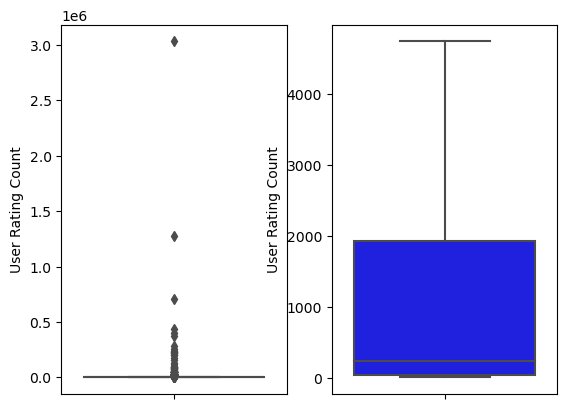

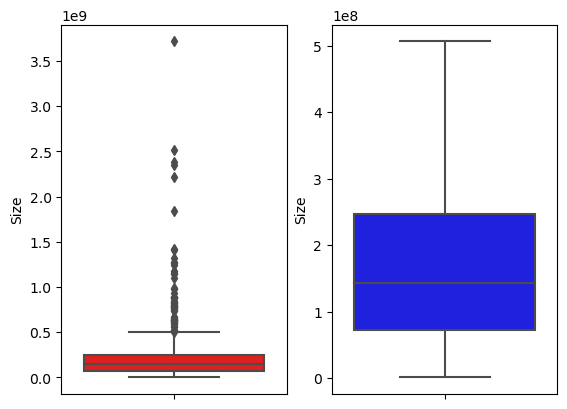

In [49]:
outliarlist=["User Rating Count","Size"]
for i in outliarlist:
    outliers(X_train,i)

<br>

## `5. Apply One Hot Encoding On Categories`

In [50]:
# replace tst with df
X_train = PreprocessListCategories(X_train,['Primary Genre', 'Genres', 'Languages'])
X_train = reduceOHEColumns(X_train)

In [51]:
X_train.shape

(860, 35)

<br>

## `6. extracting usefull information from features`

In [52]:
X_train = feature_transformation(X_train)
print(X_train['Country'].unique)
#country column should be dropped because unique count is 0
dropColumns(X_train,['Country'])
X_train = frequent_words_in_name(X_train)
X_train.rename(columns = {'Name':'frequent words in Name'}, inplace = True)

<bound method Series.unique of 5210    us
1493    us
2394    us
1805    us
1044    us
        ..
2392    us
1245    us
5039    us
3580    us
2584    us
Name: Country, Length: 860, dtype: object>


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedhafez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedhafez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
X_train.head()

,frequent words in Name,Color,User Rating Count,Price,In-app Purchases,Description,Other by developer,Age Rating,Size,Original Release Date,...,FR,IT,JA,KO,NL,PL,PT,RU,TR,ZH
5210,1,is1,0.052112,0.0,7.615000,"""Jean start new business, managing club after ...",3,1,0.154565,1446336000000000000,...,0,0,1,1,0,0,0,0,0,0
1493,3,is1,0.008861,0.0,1.990000,"If you are dreaming of space from childhood, t...",1,1,0.197224,1521331200000000000,...,0,0,0,0,0,0,0,1,0,0
2394,3,is4,0.071312,0.0,8.656667,"""That zombie apocalypse you\u2019ve always wan...",17,1,0.160754,1499644800000000000,...,0,0,0,0,0,0,0,0,0,0
1805,2,is1,1.000000,0.0,7.590000,Classic board gameplay spiced up with card sup...,2,3,0.410242,1268092800000000000,...,1,1,0,0,0,0,0,0,0,0
1044,1,is1,0.209927,0.0,30.561429,Battleplans infuses unique squad tactics into ...,1,2,0.621163,1464048000000000000,...,1,0,0,0,0,0,0,0,0,0


## Description Feature

In [54]:
# convert text to lowercase
X_train['Description'] = X_train['Description'].str.lower()
X_train['Game Difficulty'] = X_train['Description'].apply(extract_difficulty)
X_train.drop(columns='Description', inplace=True)
# Print the first 5 rows of the dataframe to verify the new columns have been added
X_train.head()

,frequent words in Name,Color,User Rating Count,Price,In-app Purchases,Other by developer,Age Rating,Size,Original Release Date,Current Version Release Date,...,IT,JA,KO,NL,PL,PT,RU,TR,ZH,Game Difficulty
5210,1,is1,0.052112,0.0,7.615000,3,1,0.154565,1446336000000000000,1523836800000000000,...,0,1,1,0,0,0,0,0,0,Easy
1493,3,is1,0.008861,0.0,1.990000,1,1,0.197224,1521331200000000000,1524528000000000000,...,0,0,0,0,0,0,1,0,0,Easy
2394,3,is4,0.071312,0.0,8.656667,17,1,0.160754,1499644800000000000,1521158400000000000,...,0,0,0,0,0,0,0,0,0,Easy
1805,2,is1,1.000000,0.0,7.590000,2,3,0.410242,1268092800000000000,1570320000000000000,...,1,0,0,0,0,0,0,0,0,Easy
1044,1,is1,0.209927,0.0,30.561429,1,2,0.621163,1464048000000000000,1555891200000000000,...,0,0,0,0,0,0,0,0,0,Easy


In [55]:
X_train['Game Difficulty'].value_counts()

Easy      590
Hard      269
Medium      1
Name: Game Difficulty, dtype: int64

## correlations

In [56]:
corrdf = pd.concat([X_train,Y_train] ,axis=1)

In [57]:
correlation_matrix = corrdf.corr()

# Get the correlation value between feature_1 and feature_2
correlation_value = correlation_matrix.loc['Size', 'Average User Rating']

print(f"The correlation between User Rating Count and Average User Rating is {correlation_value:.2f}")

The correlation between User Rating Count and Average User Rating is -0.03


In [58]:
correlation_matrix = corrdf.corr()

# Get the correlation value between feature_1 and feature_2
correlation_value = correlation_matrix.loc['Age Rating', 'Average User Rating']

print(f"The correlation between User Rating Count and Average User Rating is {correlation_value:.2f}")

The correlation between User Rating Count and Average User Rating is -0.01


In [59]:
correlation_matrix = corrdf.corr()

# Get the correlation value between feature_1 and feature_2
correlation_value = correlation_matrix.loc['In-app Purchases', 'Average User Rating']

print(f"The correlation between User Rating Count and Average User Rating is {correlation_value:.2f}")

The correlation between User Rating Count and Average User Rating is -0.02


In [60]:
correlation_matrix = corrdf.corr()

# Get the correlation value between feature_1 and feature_2
correlation_value = correlation_matrix.loc['Price', 'Average User Rating']

print(f"The correlation between User Rating Count and Average User Rating is {correlation_value:.2f}")

The correlation between User Rating Count and Average User Rating is -0.06


## Feature Selection

In [61]:
top_f = selection(X_train,Y_train)
print(top_f)
X_train = X_train[top_f]

Index(['User Rating Count', 'Original Release Date'], dtype='object')


# Preprocess Test data

In [62]:
PreProcessAgrRating(X_test)
ConvertToDateTime(X_test, ['Original Release Date', 'Current Version Release Date'])
X_test.drop(columns=['Subtitle'], inplace=True)
FillColumnNulls(X_test, 'In-app Purchases')
FillColumnNulls(X_test, 'Price')
X_test['Languages'] = X_test['Languages'].fillna('EN')
X_test = avarage_Purchases(X_test, 'In-app Purchases')
X_test["Price"] = X_test["Price"].apply(lambda x: 1 if x > 0 else x)
X_test = PreprocessListCategories(X_test,['Primary Genre', 'Genres', 'Languages'])
X_test = reduceOHEColumns(X_test)
apply_scaling(X_test)

Data type of Age Rating is,  object
Data type of Age Rating after processing is  int64
4178    3
1757    1
371     1
3056    1
2078    2
Name: Age Rating, dtype: int64


/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1163: UserWarning: Parsing '27/04/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1163: UserWarning: Parsing '19/10/2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1163: UserWarning: Parsing '16/09/2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1163: UserWarning: Parsing '31/01/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(a

# Train and test Models

Linear Regression Model

In [63]:
ModelA = linear_model.LinearRegression()
ModelA.fit(X_train, Y_train)
p = ModelA.predict(X_train)
print("Model A accurecy Train",r2_score(Y_train, p))
print('Mean Square Error Train', metrics.mean_squared_error(Y_train, p))
saved_modelA = pickle.dumps(ModelA)

Model A accurecy Train 0.01004593665625586
Mean Square Error Train 0.3157934723076702


In [64]:
ModelA = pickle.loads(saved_modelA)
Y_pred = ModelA.predict(X_test[top_f])
accuracy = r2_score(Y_test, Y_pred)
print("Model A accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))

Model A accurecy Test 0.01559168182251447
Mean Square Error Test 0.26445318411259133


SVR Model

In [65]:
from sklearn.svm import SVR
ModelB = SVR()
ModelB.fit(X_train, Y_train)
p = ModelB.predict(X_train)
print("Model B accurecy Train",r2_score(Y_train, p))
print('Mean Square Error Train', metrics.mean_squared_error(Y_train, p))
saved_modelB = pickle.dumps(ModelB)

Model B accurecy Train -0.04104988263111897
Mean Square Error Train 0.3320929419402954


In [66]:
ModelB = pickle.loads(saved_modelB)
Y_pred = ModelB.predict(X_test[top_f])
accuracy = r2_score(Y_test, Y_pred)
print("Model B accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))

Model B accurecy Test -0.024177903497312192
Mean Square Error Test 0.2751369555461128


Decision Tree Model

In [67]:
from sklearn.tree import DecisionTreeRegressor
ModelC = DecisionTreeRegressor()
ModelC.fit(X_train, Y_train)
p = ModelC.predict(X_train)
print("Model C accurecy Train",r2_score(Y_train, p))
print('Mean Square Error Train', metrics.mean_squared_error(Y_train, p))
saved_modelC = pickle.dumps(ModelC)

Model C accurecy Train 0.9995443583081494
Mean Square Error Train 0.00014534883720930232


In [68]:
ModelC = pickle.loads(saved_modelC)
Y_pred = ModelC.predict(X_test[top_f])
accuracy = r2_score(Y_test, Y_pred)
print("Model C accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))


Model C accurecy Test -0.5897875735514111
Mean Square Error Test 0.4270833333333333


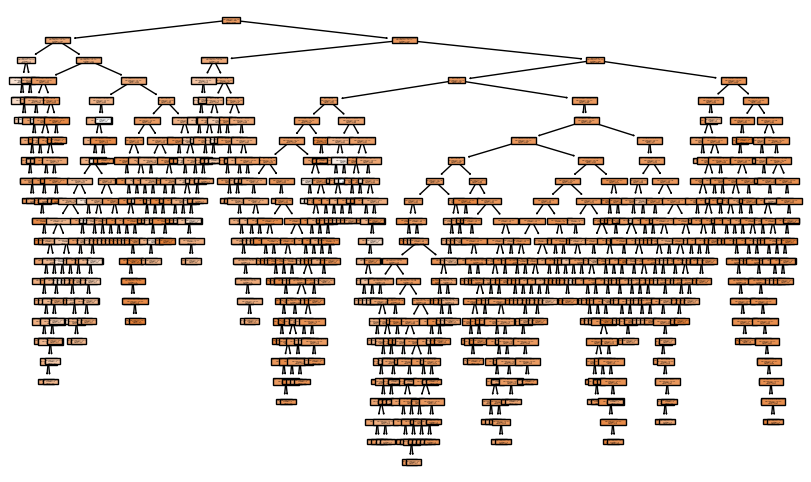

In [69]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
import pickle
# plot the decision tree
plt.figure(figsize=(10, 6))
plot_tree(ModelC, feature_names=['X1', 'X2'], filled=True)
plt.show()



Random Forest Model

In [70]:
from sklearn.ensemble import RandomForestRegressor
ModelD = RandomForestRegressor()
ModelD.fit(X_train, Y_train)
p = ModelD.predict(X_train)
print("Model D accurecy Train",r2_score(Y_train, p))
print('Mean Square Error Train', metrics.mean_squared_error(Y_train, p))
saved_modelD = pickle.dumps(ModelD)

Model D accurecy Train 0.8599778299787744
Mean Square Error Train 0.0446668071866925


In [71]:
ModelD = pickle.loads(saved_modelD)
Y_pred = ModelD.predict(X_test[top_f])
accuracy = r2_score(Y_test, Y_pred)
print("Model D accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))

Model D accurecy Test 0.0878344341079087
Mean Square Error Test 0.2450457639210391


K Neighbors Regressor Model

In [72]:
from sklearn.neighbors import KNeighborsRegressor
ModelE = KNeighborsRegressor()
ModelE.fit(X_train, Y_train)
p = ModelE.predict(X_train)
print("Model E accurecy Train",r2_score(Y_train, p))
print('Mean Square Error Train', metrics.mean_squared_error(Y_train, p))
saved_modelE = pickle.dumps(ModelE)

Model E accurecy Train 0.28158063162534797
Mean Square Error Train 0.22917441860465115


In [73]:
ModelE = pickle.loads(saved_modelE)
Y_pred = ModelE.predict(X_test[top_f])
accuracy = r2_score(Y_test, Y_pred)
print("Model E accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))

Model E accurecy Test -0.21478727435922984
Mean Square Error Test 0.3263425925925926


XGBoost Regressor Model

In [74]:
ModelF = xgb.XGBRegressor(objective="reg:linear", random_state=42)
ModelF.fit(X_train, Y_train)
p = ModelF.predict(X_train)
print("Model F accurecy Test",r2_score(Y_train, p))
print('Mean Square Error Test', metrics.mean_squared_error(Y_train, p))
saved_modelF = pickle.dumps(ModelF)

[23:29:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model F accurecy Test 0.9617653333154766
Mean Square Error Test 0.012196786297385437


In [75]:
ModelF = pickle.loads(saved_modelF)
Y_pred = ModelF.predict(X_test[top_f])
accuracy = r2_score(Y_test, Y_pred)
print("Model F accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))

Model F accurecy Test -0.20037442461150134
Mean Square Error Test 0.32247069925571


Lasso Regression Model

In [76]:
ModelG = Lasso(alpha = 10)
ModelG.fit(X_train, Y_train)
p = ModelG.predict(X_train)
print("Model G accurecy Train",r2_score(Y_train, p))
print('Mean Square Error Train', metrics.mean_squared_error(Y_train, p))
saved_modelG = pickle.dumps(ModelG)

Model G accurecy Train 0.01004593665625586
Mean Square Error Train 0.3157934723076702


In [93]:
a = X_train["User Rating Count"]

In [94]:
b = X_train["Original Release Date"]

(860, 2)


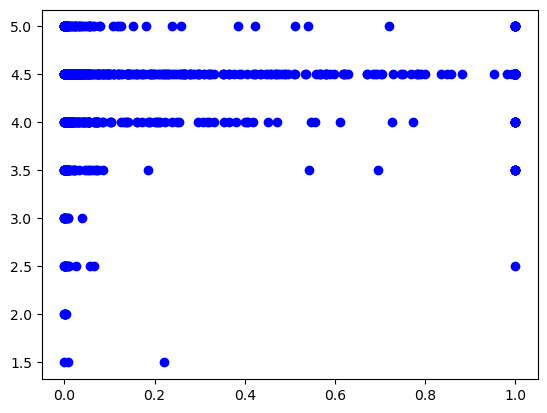

In [97]:
import matplotlib.pyplot as plt

# check the dimensions of X_train
print(X_train.shape) # output: (n_samples, n_features)

# plot the data points
plt.scatter(a, Y_train, color='blue')

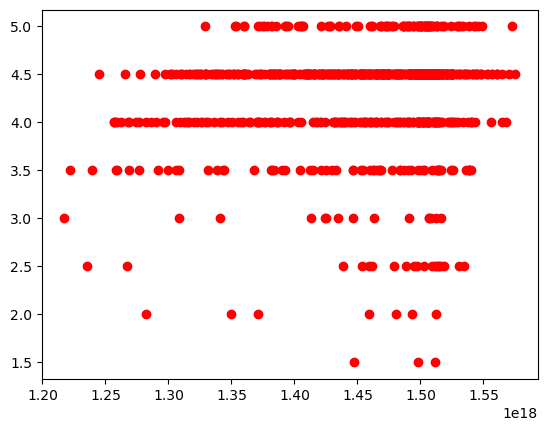

In [98]:
plt.scatter(b, Y_train, color='red')

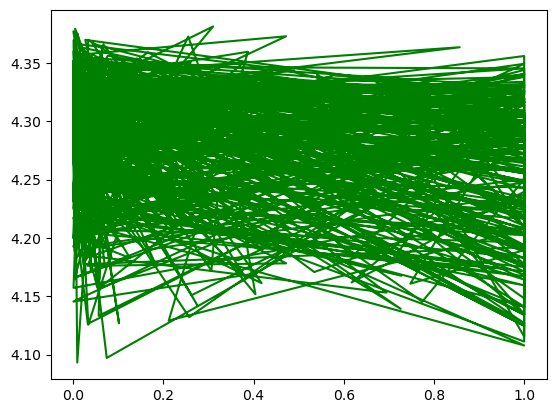

In [99]:
# plot the regression line
plt.plot(a, ModelG.predict(X_train), color='green')

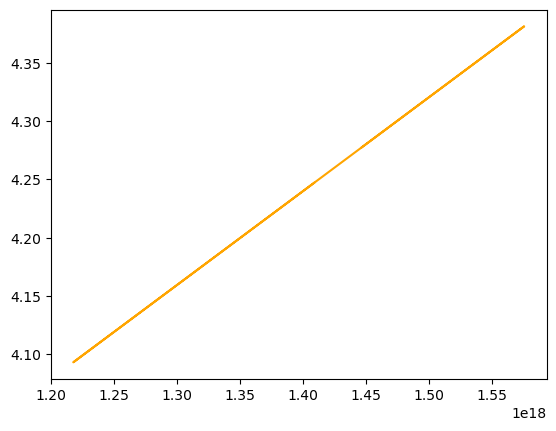

In [100]:

plt.plot(b, ModelG.predict(X_train), color='orange')

In [ ]:

# set the axis labels and title
plt.xlabel('X features')
plt.ylabel('Y')
plt.title('Lasso Regression')

# show the plot
plt.show()

In [78]:
ModelG = pickle.loads(saved_modelG)
Y_pred = ModelG.predict(X_test[top_f])
accuracy = r2_score(Y_test, Y_pred)
print("Model G accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))

Model G accurecy Test 0.01559168182251447
Mean Square Error Test 0.26445318411259133


Ridge Regression Model

In [79]:
ModelH = Ridge(alpha=10)
ModelH.fit(X_train, Y_train)
p = ModelH.predict(X_train)
print("Model H accurecy Train",r2_score(Y_train, p))
print('Mean Square Error Train', metrics.mean_squared_error(Y_train, p))
saved_modelH = pickle.dumps(ModelH)

Model H accurecy Train 0.054883638922244016
Mean Square Error Train 0.3014903301587832


/Users/ahmedhafez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.86485e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [80]:
ModelH = pickle.loads(saved_modelH)
Y_pred = ModelH.predict(X_test[top_f])
accuracy = r2_score(Y_test, Y_pred)
print("Model C accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))

Model C accurecy Test -1.5560100755943678
Mean Square Error Test 0.6866510477747966
